<a href="https://colab.research.google.com/github/elka97/MachineLearningInBusiness/blob/main/homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Расмотрим пример на датасете из репозитория UCI

Описание данных - https://archive.ics.uci.edu/ml/datasets/banknote+authentication#

In [ ]:
from __future__ import division, print_function
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
DATA_PATH = "/gdrive/My Drive/Ml_In_Business/lection6_materials/"
training_dir = f"{DATA_PATH}/catboost_info/" 
DATA_PATH

'/gdrive/My Drive/Ml_In_Business/lection6_materials/'

In [ ]:
# data = pd.read_csv(f"{DATA_PATH}data_banknote_authentication.csv", header=None)
data = pd.read_csv(f"{DATA_PATH}wine.data") #, header=None)
data.head(3)

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


In [ ]:
print(data.shape)

(178, 14)


In [ ]:
data.describe()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Посмотрим на соотношение классов

In [ ]:
data["class"].value_counts()

2    71
1    59
3    48
Name: class, dtype: int64

Join classes 1 and 2 in one target (negative), othrs -to positive class for binary classification

In [63]:
data.loc[data["class"]==1, "class_binary"]=0
data.loc[data["class"]==2, "class_binary"]=0    
data.loc[data["class"]==3, "class_binary"]=1
# data.loc[data["class"]==1, "class_binary"]=1
# data.loc[data["class"]==2, "class_binary"]=1

In [64]:
data["class_binary"].value_counts()

0    130
1     48
Name: class_binary, dtype: int64

У нас есть 4 признака и 1 целевая переменная (бинарная) - нужно определить поддельная купюра или нет

Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [67]:
data["class_test"] = -1
data.loc[data["class_binary"]==1, "class_test"]=1  

In [68]:
data["class_test"].value_counts()

-1    130
 1     48
Name: class_test, dtype: int64

Всего 1372 купюры

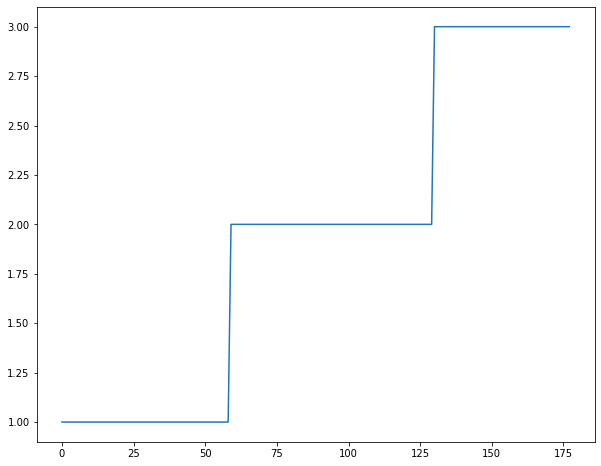

In [37]:
plt.figure(figsize=(10, 8))
plt.plot(data["class"])
plt.show()

Разбиваем выборку на тренировочную и тестовую части и обучаем модель (в примере - градиентный бустинг)

In [ ]:
from sklearn.model_selection import train_test_split

x_data = data.drop(columns=["class"])
y_data = data["class"]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [ ]:
x_train.head(5)

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
163,12.96,3.45,2.35,18.5,106,1.39,0.70,0.40,0.94,5.28,0.68,1.75,675
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
11,14.12,1.48,2.32,16.8,95,2.20,2.43,0.26,1.57,5.00,1.17,2.82,1280
168,13.58,2.58,2.69,24.5,105,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750
27,13.30,1.72,2.14,17.0,94,2.40,2.19,0.27,1.35,3.95,1.02,2.77,1285


In [ ]:
y_data.shape, x_data.shape

((178,), (178, 13))

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((142, 13), (36, 13), (142,), (36,))

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

In [ ]:
y_predict

Проверяем качество

In [ ]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(_y_test, _y_predict):
    print('Classification results:')
    f1 = f1_score(_y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(_y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(_y_test, _y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(_y_test, _y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

    
evaluate_results(y_test, y_predict)

Classification results:


ValueError: ignored

### Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

In [ ]:
mod_data = data.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 153/610 as positives and unlabeling the rest


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [ ]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    1219
 1     153
Name: class_test, dtype: int64


* We now have just 153 positive samples labeled as 1 in the 'class_test' col while the rest is unlabeled as -1.

* Recall that col 4 still holds the actual label

In [ ]:
mod_data.head(10)

,0,1,2,3,4,class_test
0,3.62160,8.6661,-2.80730,-0.44699,0,-1
1,4.54590,8.1674,-2.45860,-1.46210,0,-1
2,3.86600,-2.6383,1.92420,0.10645,0,-1
3,3.45660,9.5228,-4.01120,-3.59440,0,-1
4,0.32924,-4.4552,4.57180,-0.98880,0,-1
5,4.36840,9.6718,-3.96060,-3.16250,0,-1
6,3.59120,3.0129,0.72888,0.56421,0,-1
7,2.09220,-6.8100,8.46360,-0.60216,0,-1
8,3.20320,5.7588,-0.75345,-0.61251,0,-1
9,1.53560,9.1772,-2.27180,-0.73535,0,-1


Remember that this data frame (x_data) includes the former target variable that we keep here just to compare the results

[:-2] is the original class label for positive and negative data [:-1] is the new class for positive and unlabeled data

In [ ]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

### 1. random negative sampling

In [ ]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(153, 6) (153, 6)


In [ ]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

Classification results:
f1: 96.24%
roc: 97.37%
recall: 98.51%
precision: 94.08%


### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

<b>Бонусный вопрос:</b>

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Ваш ответ здесь: